This Jupyter notebook contains the code used to produce the figures in the paper "Characterizing the Multisectoral Impacts of Future Global Hydrologic Variability" by Birnbaum et al. currently under review.

# Import Statements

Begin by importing the following relavent Python libraries/packages

In [1]:
#load in self-defined functions in HydroVar_functions.py
from stochastic_error_model import *
from HydroVar_functions import *

# general useful packages
import time, os, math, random
import pandas as pd # data analysis
import numpy as np # numerical analysis
import geopandas as gpd # spatial analysis

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import TwoSlopeNorm

# modeling packages (stats and machine learning)
import statsmodels.api as sm
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

And also set the color palette used for most of the figures

In [2]:
# set color palette
cpal = sns.color_palette('Paired',12)

# Load in data

In [3]:
#set path to data
fpath = 'C:/Users/birnb/Documents/Tufts Research/GCIMS/birnbaum-etal_2024_HydroVariability/Data/'
histfile = 'Runoff_data/hist_annual.csv'
futfile = 'Runoff_data/fut_annual_gfdl_ssp370.csv'

#load in runoff data
df = pd.read_csv(fpath+histfile) #load in historical data
df_fut = pd.read_csv(fpath+futfile) #load in future data

#load in basin shapefiles
gcam_basins = gpd.read_file(fpath+'Shapefiles_for_mapping/gcam_basins.shp')
gcam_basins['basin_id'] = gcam_basins['sbRgnAl'].copy()

# Run Stochastic Model for 1000 simulations

In [4]:
m = 1000 # set number of stochastic realizations

Q = future_stoch_mvnorm(df,df_fut,m) #simulate stochastic realizations
Q[Q<0] = 0 # make sure there are no negative runoff values - set minimum to be zero for both historical and future

basin_nms = df.basin_name.unique() # get basin names
nbasins = len(basin_nms) # get # of basins
nyears = len(df['year'].unique()[:]) # get # of years

# get historical values
Q_hist = Q[:nyears,:,:]
q_ref = np.reshape(df.groupby(['basin_id'],group_keys=False)['q_obs'].apply(lambda x:x).to_numpy(),
                       (nyears,nbasins),order='F')
q_det = np.reshape(df.groupby(['basin_id'],group_keys=False)['q_det'].apply(lambda x:x).to_numpy(),
                   (nyears,nbasins),order='F')

# get future values
Q_fut = Q[nyears:,:,:]
nfyears = len(df_fut.year.unique()) #length 
df_fut['q_fut'] = df_fut['q_fut'].astype(float)
q_fut = np.reshape(df_fut.groupby(['basin_id'],group_keys=False)['q_fut'].apply(lambda x:x).to_numpy(),
                       (nfyears,nbasins),order='F')


## FIGURE 2: plot map, % error plot, and flow duration curves for select basins

In [5]:
gcam_basins['basin_id'] = gcam_basins['sbRgnAl'].copy()

In [6]:
#calculate deterministic model NSE
nse_det = np.zeros([nbasins,2]) # create empty storage array for NSE

for i in range(nbasins): # loop through basins
    df_basin = df[df.basin_name==basin_nms[i]] 
    boi_obs = df_basin.q_obs.to_numpy() # observed runoff
    boi_det = df_basin.q_det.to_numpy() # deterministic model runoff
    nse_det[i,0] = df_basin['basin_id'].iloc[0] # first column is basin id
    nse_det[i,1] = calc_NSE(boi_obs,boi_det) #second column is NSE

nse_det = pd.DataFrame(nse_det,columns=['basin_id','nse_det']) #create dataframe
nse_det['basin_id'] = nse_det['basin_id'].astype(int) # make basin id integer type
nse_det = gcam_basins.merge(nse_det,on=['basin_id']) # merge with geopandas gcam_basins for plotting

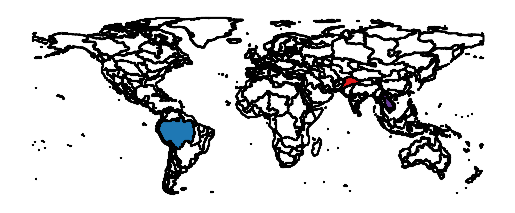

In [7]:
key_basins = ['Amazon','Indus','Mekong'] # select basins to highlight
 
df_key = df[df.basin_name.isin(key_basins)] # create dataframe of these key basins
key_ids = df_key.basin_id.unique() #get basin ids for these key basins

clist = [cpal[1],cpal[5],cpal[9]] # set colors for plotting

# plot map highlighting key basins
fig,ax = plt.subplots(1,1,)
gcam_key_basins = gcam_basins[gcam_basins.basin_id.isin(key_ids)]
gcam_key_basins = gcam_key_basins.sort_values(by='subRegn',ascending=True)
gcam_key_basins['c'] = clist
gcam_basins.boundary.plot(ax=ax,color='k')
gcam_key_basins.plot(ax=ax,color=gcam_key_basins['c'])
ax.set_axis_off()
plt.show()

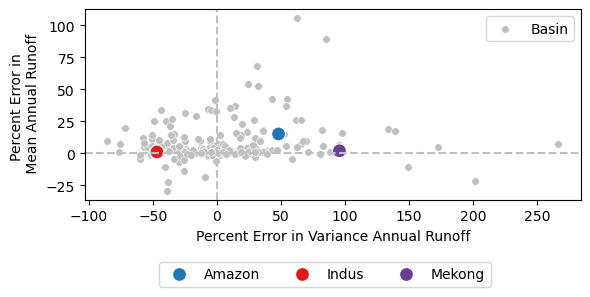

In [46]:
#calculate %error of mean and variance for all basins
df_err = df.copy() #copy dataframe 
df_mean = df_err.groupby(['basin_name','basin_id'])[['q_obs','q_det']].mean().reset_index() # get mean
df_std = df_err.groupby(['basin_name','basin_id'])[['q_obs','q_det']].std().reset_index() # get standard deviation
df_err = df_mean.merge(df_std,on=['basin_name','basin_id'],suffixes=['_mean','_std']) # merge dataframes
df_err['q_obs_cv'] = df_err['q_obs_std']/df_err['q_obs_mean'] # calculate coefficient of variantion of reference
df_err['q_det_cv'] = df_err['q_det_std']/df_err['q_det_mean'] # calculate coefficient of variation of deterministic
df_err['q_obs_var'] = df_err['q_obs_std']**2 # calculate variance of reference
df_err['q_det_var'] = df_err['q_det_std']**2 # calculate variance of determinsitic 
df_err['perr_mean'] = 100*((df_err.q_det_mean - df_err.q_obs_mean)/df_err.q_obs_mean) # % error of mean
df_err['perr_cv'] = 100*((df_err.q_det_cv - df_err.q_obs_cv)/df_err.q_obs_cv) # % error of CV
df_err['perr_var'] = 100*((df_err.q_det_var - df_err.q_obs_var)/df_err.q_obs_var) # % error of variance
df_err_key = df_err[df_err.basin_name.isin(key_basins)] # now isolate just key basins

#plot percent error mean versus percent error variance
fig,ax = plt.subplots(1,1) #initialize plot
plt.axhline(0,color='silver',ls='--') # horizontal line at zero (ideal)
plt.axvline(0,color='silver',ls='--') # vertical line at zero (ideal)
sns.scatterplot(data=df_err,y='perr_mean',x='perr_var',color='silver',s=30,label='Basin') # plot all basins
ax.legend(title='')
sns.scatterplot(data=df_err_key,y='perr_mean',x='perr_var',hue='basin_name',palette=clist,
               hue_order=['Amazon','Indus','Mekong'],s=100,legend=True) # plot key basins
plt.ylabel('Percent Error in \n Mean Annual Runoff'); plt.xlabel('Percent Error in Variance Annual Runoff')
h, l = ax.get_legend_handles_labels()
plt.legend(h[:1],l[:1],title='')
fig.legend(h[1:],l[1:],title='',loc='lower center',bbox_to_anchor=[0.5,0.1],ncol=3)
ax.set_aspect('equal', adjustable='box')
plt.show()

In [9]:
display(df_err_key)

,basin_name,basin_id,q_obs_mean,q_det_mean,q_obs_std,q_det_std,q_obs_cv,q_det_cv,q_obs_var,q_det_var,perr_mean,perr_cv,perr_var
8,Amazon,168,5947.335918,6846.810495,459.471403,559.283047,0.077257,0.081685,211113.969893,312797.527149,15.123991,5.732215,48.165243
88,Indus,89,238.747099,241.313829,45.774848,33.415865,0.191729,0.138475,2095.336698,1116.620030,1.075083,-27.775975,-46.709279
118,Mekong,125,512.684832,522.772270,61.730281,86.363034,0.120406,0.165202,3810.627566,7458.573681,1.967571,37.204250,95.730849


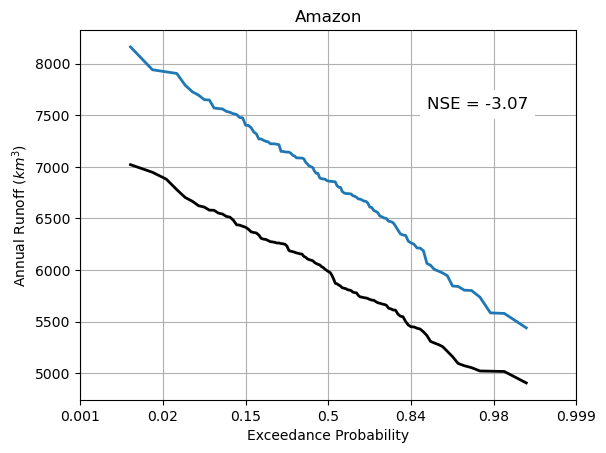

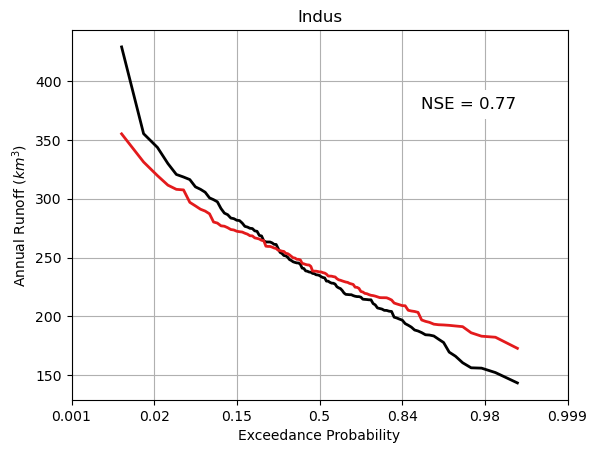

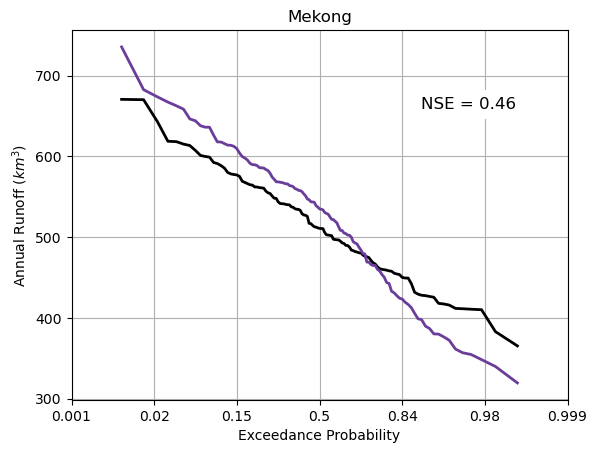

In [10]:
# plot flow duration curves for deterministic/observed:
for i in range(len(key_basins)): # loop through key basins

    #get basin runoff and ID
    df_basin = df[df.basin_name==key_basins[i]]
    df_basin_fut = df_fut[df_fut.basin_name==key_basins[i]]
    bsid = df_basin.basin_id.iloc[0] - 1
    
    # get associated NSE for that basin
    key_id = df_basin.basin_id.iloc[0]
    key_nse = nse_det[nse_det.basin_id==key_id]['nse_det'].iloc[0]

    #plot flow duration curve
    fig,ax = plt.subplots(1,1)
    plot_pexc(df_basin,Q_hist[:,bsid,:],df_basin_fut,Q_fut[:,bsid,:],clist[i],plot_type='hist_det',ax=ax) #plot
    ax.text(0.8,0.8,'NSE = '+str(round(key_nse,2)),bbox={'facecolor':'white', 'edgecolor':'none', 'pad':5},ha='center',va='center',transform=ax.transAxes,fontsize=12)

# Figure 3: Assess SWM Performance

Here, we look at model performance (bias, variance, correlation) for each basin across both deterministic model and 1,000-member stochastic ensemble

In [11]:
basin_nms = df['basin_name'].unique() #get list of basin names
basin_ids = df['basin_id'].unique()

#empty storage arrays
rho_det = np.zeros(nbasins)
delta_det = np.zeros(nbasins)
alpha_det = np.zeros(nbasins)
rho_stoch_median = np.zeros(nbasins)
delta_stoch_median = np.zeros(nbasins)
alpha_stoch_median = np.zeros(nbasins)

#for each basin
for j in range(nbasins):
    bsid = j+1
    df_basin = df[df.basin_id==bsid]
    bsnm = df_basin.basin_name.iloc[0]
    df_basin_stoch = Q_hist[:,bsid-1,:]

    #calculate bias, variance, correlation using mean, standard
    #deviation, rho, delta, alpha
    
    #observed
    mu_obs = np.mean(df_basin.q_obs)
    sig_obs = np.std(df_basin.q_obs)

    #deterministic
    mu_det = np.mean(df_basin.q_det)
    sig_det = np.std(df_basin.q_det)
    rho_det[j] = np.corrcoef(df_basin.q_obs,df_basin.q_det)[0,1]
    delta_det[j] = (mu_obs - mu_det)/mu_obs
    alpha_det[j] = sig_det/sig_obs

    #stochastic
    mu_stoch = np.mean(df_basin_stoch,axis=0)
    sig_stoch = np.std(df_basin_stoch,axis=0)
    rho_stoch = np.zeros(m)
    for i in range(m):
        rho_stoch[i] = np.corrcoef(df_basin.q_obs,df_basin_stoch[:,i])[0,1]
    delta_stoch= (mu_obs - mu_stoch)/mu_obs
    alpha_stoch = sig_stoch/sig_obs
    #median of stochastic
    rho_stoch_median[j] = np.median(rho_stoch)
    delta_stoch_median[j] = np.median(delta_stoch)
    alpha_stoch_median[j] = np.median(alpha_stoch)
    
#create data frame of mdoel statistics (rho, delta, alpha)
model_stats = pd.DataFrame()
model_stats['basin_nm'] = basin_nms
model_stats['basin_id'] = basin_ids
model_stats['rho_det'] = rho_det
model_stats['delta_det'] = delta_det
model_stats['alpha_det'] = alpha_det
model_stats['rho_stoch_median'] = rho_stoch_median
model_stats['delta_stoch_median'] = delta_stoch_median
model_stats['alpha_stoch_median'] = alpha_stoch_median
model_stats = gcam_basins.merge(model_stats,on=['basin_id'])


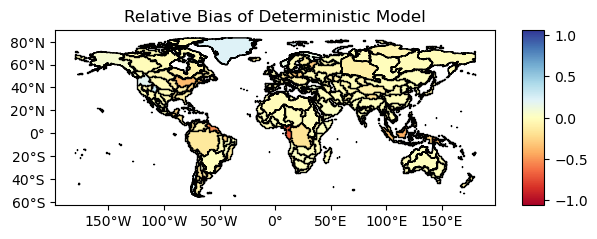

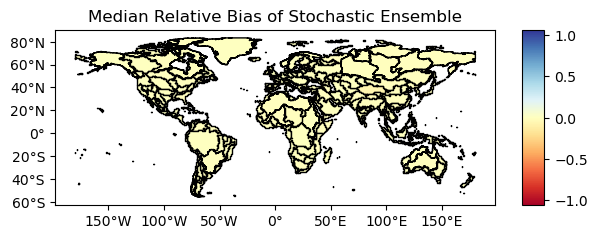

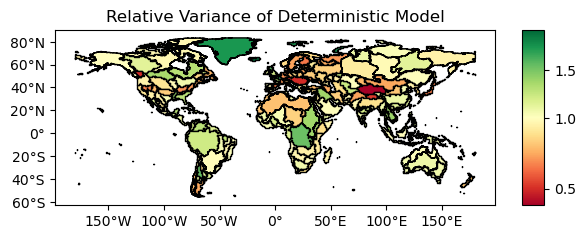

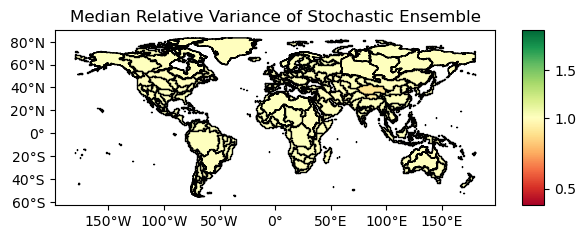

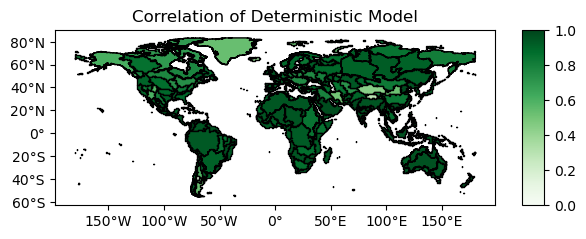

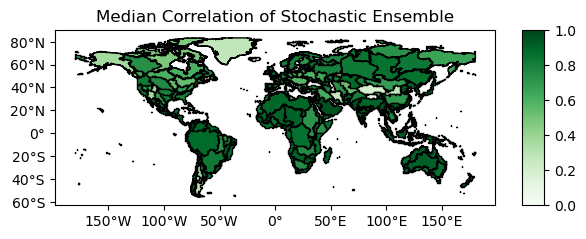

In [12]:
#define min and max vals for each set of maps

#min, max for bias
dmin = np.min([model_stats.delta_det.min(),model_stats.delta_stoch_median.min()])
dmax = np.max([model_stats.delta_det.max(),model_stats.delta_stoch_median.max()])
dval = np.max([np.abs(dmin),np.abs(dmax)])

#min, max for variance
amin = np.min([model_stats.alpha_det.min(),model_stats.alpha_stoch_median.min()])
amax = np.max([model_stats.alpha_det.max(),model_stats.alpha_stoch_median.max()])

#min, max for correlation
rmin = np.min([model_stats.rho_det.min(),model_stats.rho_stoch_median.min()])
rmax = np.max([model_stats.rho_det.max(),model_stats.rho_stoch_median.max()])
rmin = 0
rmax = 1

col_names = ['delta_det','delta_stoch_median','alpha_det','alpha_stoch_median','rho_det','rho_stoch_median']
vmins = [-dval,-dval,amin,amin,rmin,rmin] #maxs
vmaxs = [dval,dval,amax,amax,rmax,rmax] #mins
vcenters = [0,0,1,1,0.5,0.5] #centers
plt_titles = ['Relative Bias of Deterministic Model','Median Relative Bias of Stochastic Ensemble',
             'Relative Variance of Deterministic Model','Median Relative Variance of Stochastic Ensemble',
             'Correlation of Deterministic Model','Median Correlation of Stochastic Ensemble']
cmaps = ['RdYlBu','RdYlBu','RdYlGn','RdYlGn','Greens','Greens']

#loop through maps (columns)
for j in range(len(col_names)):
    col_name = col_names[j]
    fig,ax = plt.subplots(1,1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    model_stats.plot(ax=ax,cax=cax,column=col_name,legend=True,cmap=cmaps[j],
                norm = mcolors.TwoSlopeNorm(vmin=vmins[j],vmax=vmaxs[j],vcenter=vcenters[j]),edgecolor='k')
    axlbl = fig.axes[0]; ticksizes = axlbl.figure; cb_ax = ticksizes.axes[0];# cb_ax.tick_params(labelsize=14)
    cb_ax.set_xticks([-150,-100,-50,0,50,100,150]); cb_ax.set_yticks([-60,-40,-20,0,20,40,60,80])
    cb_ax.set_xticklabels(['150°W','100°W','50°W','0°','50°E','100°E','150°E'])
    cb_ax.set_yticklabels(['60°S','40°S','20°S','0°','20°N','40°N','60°N','80°N'])
    cb_ax = ticksizes.axes[0]; #cb_ax.tick_params(labelsize=10);
    ax.set_title(plt_titles[j])
    plt.show()

## FIGURE X: historical SWM model performance

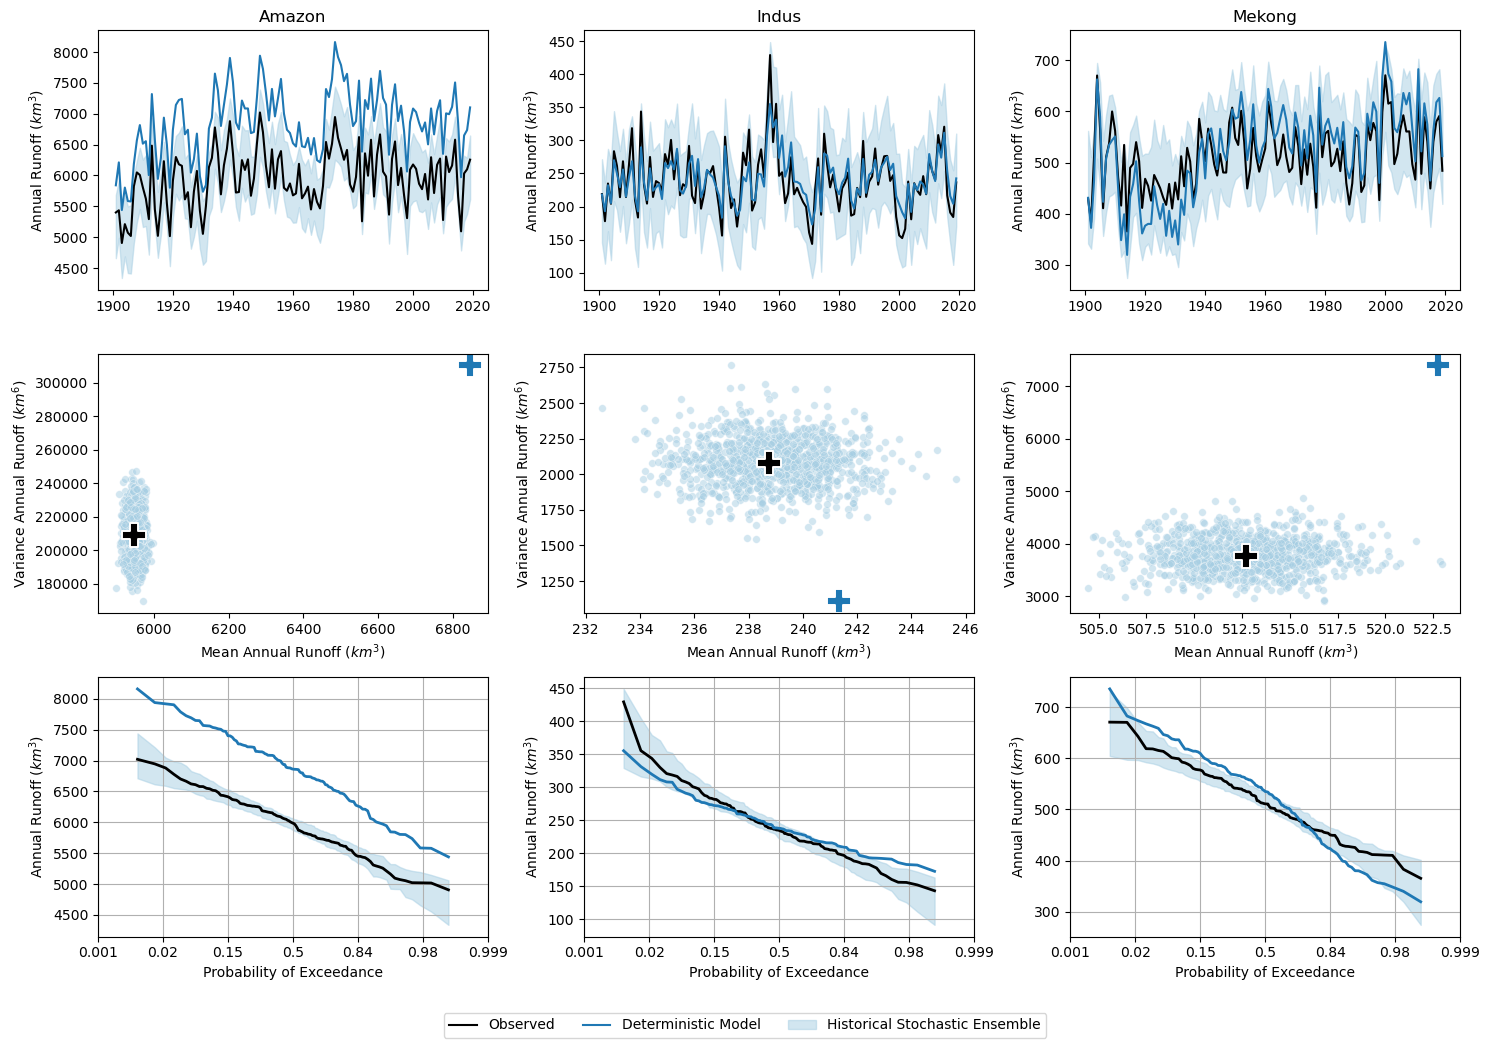

In [38]:
# results plots for a specific basin
fig,axes = plt.subplots(3,3,figsize=(15,10),gridspec_kw={'width_ratios': [1, 1,1]})
axes = axes.flatten()
bs_name_list = ['Amazon','Indus','Mekong']

#loop through basins
for i in range(len(bs_name_list)):
    bs_name = bs_name_list[i]
    bsid = df[df.basin_name==bs_name]['basin_id'].iloc[0] - 1
    df_basin = df[df.basin_name==bs_name] 
    df_basin_fut = df_fut[df_fut.basin_name==bs_name]

    boi_obs = q_ref[:,bsid] #observed
    boi_det = q_det[:,bsid] #deterministic
    boi_stoch = Q_hist[:,bsid,:] #stochastic
    boi_fdet = q_fut[:,bsid]#future
    boi_fstoch = Q_fut[:,bsid,:]#future stochastic

    # subplot 1: time series
    ax1 = axes[i]
    years = df.year.unique()[:]
    fyears = df_fut.year.unique()[:]
    sns.lineplot(ax=ax1,x=years,y=boi_obs,label='Observed',color='k',legend=True)
    sns.lineplot(ax=ax1,x=years,y=boi_det,label='Deterministic Model',color=cpal[1],legend=True)
    ax1.fill_between(years,np.min(boi_stoch,axis=1),np.max(boi_stoch,axis=1),color=cpal[0],alpha=0.5,label='Historical Stochastic Ensemble')
    ax1.set_ylabel('Annual Runoff ($km^3$)')
    ax1.tick_params(axis='both', which='major')
    ax1.set_title(bs_name)
    ax1.legend().set_visible(False)

    #second row is for scatterplots
    ax2 = axes[i+3]
    sns.scatterplot(ax=ax2,x=np.mean(boi_stoch,axis=0),y = np.var(boi_stoch,axis=0),s=30,label='Historical Stochastic Ensemble',color=cpal[0],alpha=0.5,legend=False)
    sns.scatterplot(ax=ax2,x=[np.mean(boi_obs)],y=[np.var(boi_obs)],s=300,label='Observed',color='k',legend=False,marker='P')
    sns.scatterplot(ax=ax2,x=[np.mean(boi_det)],y=[np.var(boi_det)],s=300,label='Historical Deterministic Model',color=cpal[1],legend=False,marker='P')
    ax2.set_xlabel('Mean Annual Runoff ($km^3$)')
    ax2.set_ylabel('Variance Annual Runoff ($km^6$)')
    ax2.tick_params(axis='both', which='major')
    
    #third row is for FDCs
    # subplot 3: probability of exceedance for future
    ax3 = axes[i+6]
    ax3 = plot_pexc(df_basin,Q_hist[:,bsid,:],df_basin_fut,Q_fut[:,bsid,:],cpal[1],cpal[0],'hist_stoch',ax=ax3,)
    ax3.set_xlabel('Probability of Exceedance')
    ax3.set_ylabel('Annual Runoff ($km^3$)')
    ax3.set_title('')
    ax3.tick_params(axis='both', which='major')
    ax3.legend().set_visible(False)
plt.tight_layout()
h, l = ax1.get_legend_handles_labels()
fig.legend(h[0:],l[0:],title='',loc='lower center',bbox_to_anchor=[0.5,-0.05],ncol=3)

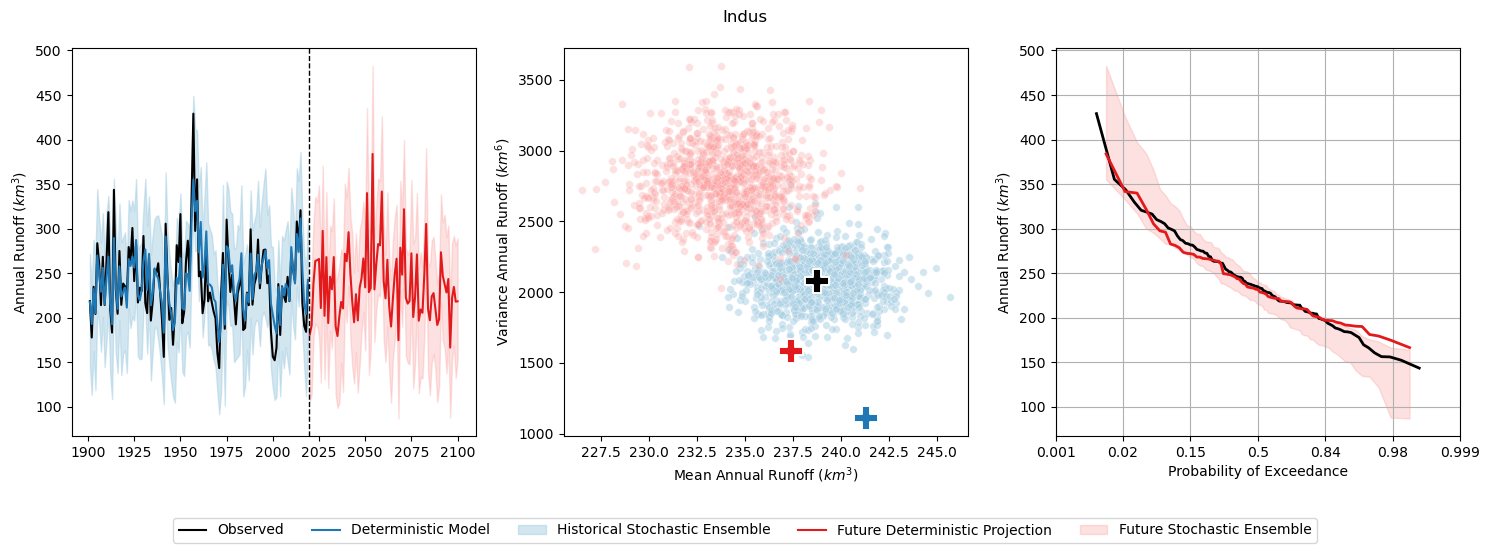

In [29]:
# results plots for a specific basin
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5),
                                 gridspec_kw={'width_ratios': [1, 1,1]})

bs_name = 'Indus'
bsid = df[df.basin_name==bs_name]['basin_id'].iloc[0] - 1

boi_obs = q_ref[:,bsid] #observed
boi_det = q_det[:,bsid] #deterministic
boi_stoch = Q_hist[:,bsid,:] #stochastic
boi_fdet = q_fut[:,bsid]#future
boi_fstoch = Q_fut[:,bsid,:]#future stochastic
df_basin = df[df.basin_name==bs_name] 
df_basin_fut = df_fut[df_fut.basin_name==bs_name]

# subplot 1: time series
years = df.year.unique()[:]
fyears = df_fut.year.unique()[:]
sns.lineplot(ax=ax1,x=years,y=boi_obs,label='Observed',color='k',legend=False)
sns.lineplot(ax=ax1,x=years,y=boi_det,label='Deterministic Model',color=cpal[1],legend=False)
ax1.fill_between(years,np.min(boi_stoch,axis=1),np.max(boi_stoch,axis=1),color=cpal[0],alpha=0.5,label='Historical Stochastic Ensemble')
sns.lineplot(ax=ax1,x=fyears,y=boi_fdet,label='Future Deterministic Projection',color=cpal[5],legend=False)
ax1.fill_between(fyears,np.min(boi_fstoch,axis=1),np.max(boi_fstoch,axis=1),color=cpal[4],alpha=0.3,label='Future Stochastic Ensemble')
ax1.axvline(years[-1]+0.5,color='k',lw=1,ls='--')
ax1.set_ylabel('Annual Runoff ($km^3$)')

# subplot 2: plot scatterplots of mean vs variance in annual runoff
sns.scatterplot(ax=ax2,x=np.mean(boi_stoch,axis=0),y = np.var(boi_stoch,axis=0),s=30,
                label='Historical Stochastic Ensemble',color=cpal[0],alpha=0.5,legend=False)
sns.scatterplot(ax=ax2,x=np.mean(boi_fstoch,axis=0),y = np.var(boi_fstoch,axis=0),s=30,
                label='Future Stochastic Ensemble',color=cpal[4],legend=False,alpha=0.3)
sns.scatterplot(ax=ax2,x=[np.mean(boi_obs)],y=[np.var(boi_obs)],s=300,label='Observed',color='k',legend=False,marker='P')
sns.scatterplot(ax=ax2,x=[np.mean(boi_det)],y=[np.var(boi_det)],s=300,label='Historical Deterministic Model',
                color=cpal[1],legend=False,marker='P')
sns.scatterplot(ax=ax2,x=[np.mean(boi_fdet)],y=[np.var(boi_fdet)],s=300,label='Future Deterministic Projection',
                color=cpal[5],legend=False,marker='P')
ax2.set_xlabel('Mean Annual Runoff ($km^3$)')
ax2.set_ylabel('Variance Annual Runoff ($km^6$)')

# subplot 3: probability of exceedance for future
ax3 = plot_pexc(df_basin,Q_hist[:,bsid,:],df_basin_fut,Q_fut[:,bsid,:],cpal[5],cpal[0],'fut_stoch',ax3)
ax3.set_xlabel('Probability of Exceedance')
ax3.set_ylabel('Annual Runoff ($km^3$)')
ax3.set_title('')
ax3.legend().set_visible(False)

plt.suptitle(bs_name)
plt.tight_layout()

h, l = ax1.get_legend_handles_labels()
fig.legend(h[0:],l[0:],title='',loc='lower center',bbox_to_anchor=[0.5,-0.1],ncol=5)